### Preliminary cell to start the notebook

In [41]:
# libraries
import os
import sys
import platform
print(sys.version)

strong_pc = platform.system() == 'Linux'
in_colab = 'google.colab' in sys.modules
if in_colab:
    if not os.getcwd().split('/')[-1].split('_')[-1]=='2023':
        from google.colab import drive
        drive.mount('/content/drive')
        os.chdir(r'/content/drive/MyDrive/Human_Data_Analytics_Project_2023')

    #!pip install tensorflow==2.11.0
    #!pip install tensorflow_text==2.11.0
    if not 'tensorflow_io' in sys.modules:
        print('Installing tensorflow-IO')
        !pip install tensorflow-io
    if not 'keras' in sys.modules and False:
        print('Installing keras')
        !pip install keras==2.11.0
    if not 'scikeras' in sys.modules:
        print('Installing scikeras')
        !pip install scikeras[tensorflow]
    if not 'keras-tuner' in sys.modules:
        print('installing keras tuner')
        !pip install keras-tuner
        !pip install numba==0.57.0


if 'DEEPNOTE_ENV' in os.environ:
    os.chdir('/..')
    os.chdir('datasets')
    os.chdir('googledrivedeepnoteintegration')
    os.chdir('Human_Data_Analytics_Project_2023')
    if not 'librosa' in sys.modules:
        print('Installing Librosa')
        !pip install librosa
    if not 'scikeras' in sys.modules:
        print('Installing scikeras')
        !pip install scikeras[tensorflow]
    if not 'keras-tuner' in sys.modules:
        print('installing keras tuner')
        !pip install keras-tuner
        !pip install numba==0.57.0

main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)

#BASE LIBRARIES
import numpy as np
import pandas as pd
import h5py
import shutil
import time
import random
import subprocess
import itertools
import warnings
import pickle
import json

#PLOT LIBRARIES
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
#import plotly.express as px

#AUDIO LIBRARIES
import librosa
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft,ifft,fftfreq, fftshift
from scipy.signal import stft,spectrogram,periodogram
#from pydub import AudioSegment

#MACHINE LEARNING LIBRARIES
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import check_random_state
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras.models import load_model

# GPU SETTINGS FOR LINUX and repressing warnings for windows. References for gpu: https://www.tensorflow.org/guide/gpu
show_gpu_activity = False
if sys.platform == 'linux' and not in_colab:
    if show_gpu_activity:
        tf.debugging.set_log_device_placement(True)

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
    # Restrict TensorFlow to only allocate a part of memory on the first GPU
        try:
            tf.config.set_logical_device_configuration(
                gpus[0],
                [tf.config.LogicalDeviceConfiguration(memory_limit=6800)])
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Virtual devices must be set before GPUs have been initialized
            print(e)
else:
    warnings.filterwarnings("ignore", category=UserWarning)

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model as tf_plot
if in_colab:
    import tensorflow_io as tfio
print("TensorFlow version:", tf.__version__)
# show keras version
import keras
print(f'keras version = {keras.__version__}')
#import keras_tune as kt
from keras import layers
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.regularizers import L1L2
# kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4) # we may use this in some layers...

#RANDOM SETTINGS
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
check_random_state(seed)

#EVALUATION LIBRAIRES
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_recall_fscore_support, auc

#OUR PERSONAL FUNCTIONS
import importlib
from Preprocessing.data_loader import download_dataset,load_metadata
from Preprocessing.exploration_plots import one_random_audio, plot_clip_overview, Spectral_Analysis
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC
from Visualization.model_plot import confusion_matrix,listen_to_wrong_audio

importlib.reload(importlib.import_module('Preprocessing.data_loader'))
importlib.reload(importlib.import_module('Models.basic_ml'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Preprocessing.data_loader import load_metadata
df_ESC10, df_ESC50 = load_metadata(main_dir,heads = False, ESC_US = False, statistics=False)

from Preprocessing.data_loader import load_metadata
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC

importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Models.ann_utils import *
from Models.ann_utils import MFCCWithDeltaLayer,OutputCutterLayer
from Visualization.model_plot import plot_history, confusion_matrix, listen_to_wrong_audio, visualize_the_weights

ESC10_path = os.path.join(main_dir,'Data', 'ESC-10-depth')
samplerate = 22500

3.11.4 (main, Jul  5 2023, 08:54:11) [Clang 14.0.6 ]
TensorFlow version: 2.12.0
keras version = 2.12.0


In [42]:
main_dir = os.getcwd()
subfolder_path = os.path.join(main_dir, 'Data','balanced')

## Dataset management

Function to delete all the files which are too short or too long, we keep 10 sec files and we will sample half times

In [12]:
from pydub import AudioSegment

# Function to check audio duration
def check_audio_duration(audio_path, target_duration):
    try:
        audio = AudioSegment.from_file(audio_path)
        duration_seconds = len(audio) / 1000  # Convert milliseconds to seconds
        return duration_seconds == target_duration  # Check if duration is exactly equal to the target duration
    except Exception as e:
        return False


# Set the root folder path
root_folder = os.path.join(main_dir, 'Data', 'AudioSet')

# Target duration in seconds    
target_duration = 10
file_count = 0
remode_file = 0

# Iterate through all files in the directory and its subdirectories
for root, dirs, files in os.walk(root_folder):
    for file in files:
        # Check if the file has an audio file extension (e.g., .mp3, .wav, .ogg, etc.)
        if file.endswith(('.mp3', '.wav', '.ogg', '.flac', '.aac')):
            audio_path = os.path.join(root, file)
            file_count += 1
            if not check_audio_duration(audio_path, target_duration):
                # delete the file
                os.remove(audio_path)
                remode_file += 1


In [13]:
print(f'Number of files: {file_count}')
print(f'Number of removed files: {remode_file}') # around 3000 files removed


Number of files: 49625
Number of removed files: 2885


Renaming the folders from name = label, to name = number in order to use US_training (modified into AS_training)

In [17]:
#renaming the folders

import os
# Set the root folder path
path = os.path.join(main_dir, 'Data', 'AudioSet')
count = 1
for folder_name in sorted(os.listdir(path)):
    if os.path.isdir(os.path.join(path, folder_name)):
        # Create a new name with a three-digit number
        new_name = f"{count:03d}"
        
        # Construct the full paths to the old and new folders
        old_folder_path = os.path.join(path, folder_name)
        new_folder_path = os.path.join(path, new_name)
        
        # Rename the subfolder
        os.rename(old_folder_path, new_folder_path)
        
        count += 1

Converting wav files if needed (skipped)

In [38]:
# If we want to convert the audio files to OGG format, we can use the following code:
# But we do not do it because it takes too long, instead we use the original files modifying the function create_dataset

# Set the root folder path
root_folder = os.path.join(main_dir, 'Data', 'AudioSet')

# Iterate through all files in the directory and its subdirectories
for root, dirs, files in os.walk(root_folder):
    for file in files:
        # Check if the file has a WAV file extension
        if file.endswith('.wav'):
            # Construct the full path to the file
            file_path = os.path.join(root, file)
            
            # Specify the output OGG file path
            ogg_file_path = file_path.replace('.wav', '.ogg')
            
            # Use VLC to convert WAV to OGG format with a timeout of 60 seconds
            vlc_command = [
                '/Applications/VLC.app/Contents/MacOS/VLC',
                '--intf', 'dummy',  # Use the dummy interface (no GUI)
                '--no-sout-video',  # Disable video output
                '--sout', f'#transcode{{acodec=vorb,ab=128,channels=2,samplerate=44100}}:std{{access=file,mux=ogg,dst="{ogg_file_path}"}}',
                file_path  # Input WAV file
            ]
            
            # Run the VLC command with a timeout
            try: 
                completed_process = subprocess.run(vlc_command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, timeout=0.5)
            except subprocess.TimeoutExpired:
                #check if there exists a file with the same name and its weight is not 0
                if os.path.exists(ogg_file_path) and os.path.getsize(ogg_file_path) > 0:
                    #print(f'Converted "{file_path}" to "{ogg_file_path}"')
                    continue
                else:
                    try:
                        completed_process = subprocess.run(vlc_command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, timeout=1)
                    except subprocess.TimeoutExpired:
                        if os.path.exists(ogg_file_path) and os.path.getsize(ogg_file_path) > 0:
                            #print(f'Converted "{file_path}" to "{ogg_file_path}"')
                            continue
                        else: 
                            try:
                                completed_process = subprocess.run(vlc_command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, timeout=10)
                            except subprocess.TimeoutExpired:
                                if os.path.exists(ogg_file_path) and os.path.getsize(ogg_file_path) > 0:
                                    #print(f'Converted "{file_path}" to "{ogg_file_path}"')
                                    continue
                                else:
                                    print(f'Failed to convert "{file_path}" to "{ogg_file_path}"')
                                    continue
                    continue

## Autoencoder training (using 3.3)

In [43]:
preprocessing = 'STFT'
AE_name = 'AE_Conv_prep_flatten_'+preprocessing + '_AudioSet'

In [44]:
folder_path = 'Saved_Models'  # Replace this with the actual folder path
file_names = [ AE_name+'_count.txt']

for name in file_names:
    file_path = os.path.join(main_dir, folder_path, name)
    with open(file_path, 'w') as f:
        f.write('0')
    print(f"Created {name} with content '0' in folder {folder_path}")


Created AE_Conv_prep_flatten_STFT_AudioSet_count.txt with content '0' in folder Saved_Models


In [45]:
# Now, you have a TensorFlow dataset with spectrograms and labels.
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import librosa
from scipy.interpolate import RegularGridInterpolator

In [50]:
def create_AS_dataset(folder,val_split = 0.25): #folder = '001'
    # Create an empty list to store spectrograms and labels
    spectrograms = []

    # Define the target shape for spectrograms
    target_shape = (64, 128)

    list_audio_files = os.listdir(os.path.join(main_dir, 'Data', 'AudioSet', folder))

    for audio_file in list_audio_files:
        audio_path = os.path.join(main_dir, 'Data', 'AudioSet', folder , audio_file)
        audio, sr = librosa.load(audio_path, sr=22050, mono=True)
        stft = librosa.stft(audio)
        #stft = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

        # from create dataset function
        #stft_librosa = librosa.stft(audio, hop_length=hop_length, win_length=nperseg, n_fft=n_fft)
        #r = librosa.amplitude_to_db(np.abs(stft_librosa), ref=np.max)

        # Create a grid of indices for the original spectrogram
        x = np.linspace(0, stft.shape[1] - 1, stft.shape[1])
        y = np.linspace(0, stft.shape[0] - 1, stft.shape[0])

        # Create the interpolator function
        interpolator = RegularGridInterpolator((y, x), stft)

        # Create a grid of indices for the target shape
        target_x = np.linspace(0, stft.shape[1] - 1, target_shape[1])
        target_y = np.linspace(0, stft.shape[0] - 1, target_shape[0])

        # Create a meshgrid of target indices
        target_x, target_y = np.meshgrid(target_x, target_y)

        # Stack the indices as a 2D array
        target_indices = np.vstack((target_y.ravel(), target_x.ravel())).T

        # Interpolate to get the resized STFT
        stft = interpolator(target_indices).reshape(target_shape)

        # Change dim to (64, 128, 1)
        stft = stft.reshape(64, 128, 1)

        # Append the spectrogram and label to the lists (modify this part to include labels)
        spectrograms.append(stft)

    # Convert the lists to numpy arrays
    spectrograms = np.array(spectrograms)

    # for entry of each spectrogram take the norm since it is a complex number
    spectrograms = np.abs(spectrograms)

    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((spectrograms,spectrograms))

    # Shuffle and batch the dataset (modify batch size and buffer size as needed)
    batch_size = 32
    buffer_size = 1000

    #divide into train, val, test
    dataset = dataset.shuffle(buffer_size)
    n = len(dataset)
    n_val = int(n*val_split)
    n_test = int(n*val_split)
    n_train = n - n_val - n_test
    train = dataset.take(n_train)
    val = dataset.skip(n_train).take(n_val)
    test = dataset.skip(n_train+n_val).take(n_test)
    
    #batch the dataset
    train = train.batch(batch_size)
    val = val.batch(batch_size)
    test = test.batch(batch_size)

    INPUT_DIM = spectrograms[0].shape

    return train, val, test, INPUT_DIM

In [51]:
train, val, test, INPUT_DIM = create_AS_dataset('001')

In [52]:
def num_3(i):
    if i<10:
        return '00'+str(i)
    elif (i<100) and (i>=10):
        return '0'+str(i)
    else:
        return str(i)

In [53]:
#General function to build an autoencoder
#CONVOLUTIONAL AUTOENCODER WITH VECTORIAL CODE
code_size = 32
n_layers = 2
n_units = 32

# the real build function for general autoencoder (keras code)
def build_autoencoder(img_shape = INPUT_DIM,
                      code_size = code_size,
                      activation = 'tanh',
                      padding = 'valid',
                      n_layers = n_layers, #max number of layers is 3
                      n_units = n_units,
                      kernel_size = (3,3),
                      strides = (2,2),
                      max_pooling = (2,2),
                      regularizer = 1e-4,
                      batch_norm = True,
                      drop_out = 0.0,
                      learning_rate = 1e-3,
                      loss = tf.keras.losses.MeanSquaredError(),
                      metrics = ['mse'],
                      AE_name = AE_name
 ):
    lr = learning_rate
    # encoder
    encoder = tf.keras.Sequential(name='Encoder')
    encoder.add(tf.keras.Input(img_shape))
    for i in range(n_layers):
        encoder.add(layers.Conv2D(n_units * (i+1), kernel_size,strides = strides, activation = activation, padding=padding))
        encoder.add(layers.MaxPool2D(max_pooling, padding='same'))
        if batch_norm:
            encoder.add(layers.BatchNormalization())
        if drop_out > 0:
            encoder.add(layers.Dropout(drop_out))

    # flatten layer to get the code
    my_shape = encoder.layers[-1].output_shape
    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(code_size,activation = activation, activity_regularizer=keras.regularizers.l1(regularizer)))

    # decoder
    decoder = tf.keras.Sequential(name='Decoder')
    decoder.add(tf.keras.Input(code_size))
    decoder.add(layers.Dense(np.prod(my_shape[1:]), activation=activation))
    decoder.add(layers.Reshape(my_shape[1:]))

    # transpose convolutions
    for i in range(n_layers):
        filters = n_units * (n_layers-i) if i<n_layers-1 else 1
        decoder.add(layers.Conv2DTranspose(filters , kernel_size, strides=strides, activation=activation, padding=padding))
        decoder.add(layers.UpSampling2D(size=max_pooling))
        if batch_norm:
            decoder.add(layers.BatchNormalization())

    #final reshape
    decoder.add(tf.keras.layers.Resizing(height = INPUT_DIM[0], width = INPUT_DIM[1], interpolation="bilinear", crop_to_aspect_ratio=False))

    # build the autoencoder with keras.Model
    inp = tf.keras.Input(shape = INPUT_DIM)
    code = encoder(inp)
    reconstruction = decoder(code)
    autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction, name = AE_name)

    # compile the autoencoder
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate = lr)
    loss = loss
    metrics = metrics

    autoencoder.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)

    #print the number of trainable parameters
    print(f'Model built with { sum(tf.keras.backend.count_params(p) for p in autoencoder.trainable_variables)} trainable params')

    return autoencoder

In [54]:
def AS_training(AE_name,
                autoencoder,
                n_folders,
                epochs = 50,
                preprocessing = None,
                patience=10,
                verbose = 0,
                ndim = 3,
                metrics = ['mse'],
                ):

    #paramteres for the fit and callbacks
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_'+metrics[0],
                                                mode='max',
                                                verbose=verbose,
                                                restore_best_weights=True,
                                                patience=patience)]

    #read the file txt to know the folder to start 
    with open(os.path.join(main_dir,'Saved_Models',AE_name+'_count.txt'), 'r') as file:
        last_folder = int(file.read())
        print(f'Last folder trained: {last_folder}')

    if n_folders < last_folder:
        print('The number of folders is smaller than the last folder trained!')
        n_folders = last_folder
    
    for i in range(last_folder+1,n_folders+1):

        #load the model if i > 1
        if i>1:
            autoencoder = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models',AE_name))

        #create the dataset

        train, val, test, INPUT_DIM =  create_AS_dataset( folder = num_3(i), val_split = 0.25)
        
        #fit the autoencoder
        history = autoencoder.fit(train, validation_data= val, epochs=epochs, callbacks = callbacks, verbose=0)

        #save the model
        autoencoder.save(os.path.join(main_dir,'Saved_Models',AE_name), save_format  ='keras')

        #show the best epoch
        val_acc_per_epoch = history.history['val_'+metrics[0]]
        best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
        if verbose > 0:
            print('Best epoch: %d' % (best_epoch,))
        
        if verbose > 1:
            #plot the history of the training
            plot_history(history)

            #evaluate the model on the test set
            scores = autoencoder.evaluate(test, return_dict=False)
            display(scores)

        #update the number on the txt file overwritting the previoAS one
        with open(os.path.join(main_dir,'Saved_Models',AE_name+'_count.txt'), 'w') as file:
            file.write(str(i))

    # retrive the size of the model
    print(f"This model has a size of {get_model_size(autoencoder)} MB")
     
    return autoencoder

In [55]:
best_params = {
    'n_layers':1,
    'n_units':16,
    'kernel_size':3,
    'strides':3,
    'max_pooling':3,
    'regularizer':0.0001,
    'padding':'valid',
    'code_size':32,
    'activation':'elu',
    'drop_out':0.0,
    'batch_norm':False,
    'learning_rate':0.005,
}

# build an autoencoder with the best params
autoencoder = build_autoencoder(**best_params)

#autoencoder = tuner.get_best_models(num_models=1)[0] #to create the model with some already wuite good weights
autoencoder.summary()
verbose=0
if verbose>0:
    autoencoder.layers[1].summary()
    autoencoder.layers[2].summary()

epochs = 50 #50
n_folders = 528 #528
verbose = 0

AS_training(AE_name = AE_name, autoencoder = autoencoder, epochs = epochs , n_folders = n_folders , preprocessing = preprocessing, ndim=3, verbose=verbose)

Model built with 102257 trainable params
Model: "AE_Conv_prep_flatten_STFT_AudioSet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                50368     
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        51889     
                                                                 
Total params: 102,257
Trainable params: 102,257
Non-trainable params: 0
_________________________________________________________________
Last folder trained: 0


2023-09-10 19:37:35.802234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:36.112070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:36.465897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape 

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:37:37.969054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:38.205977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:38.514005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:37:40.629364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:37:40.857359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:41.334587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:37:43.110646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:43.323275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:43.727529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:37:45.452440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:37:45.657696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:46.054224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:37:47.458869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:47.686840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:48.014895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:37:49.611261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:49.821105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:37:50.142326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:37:52.708517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [105,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:37:52.925875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [105,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:37:54.245759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:37:56.118964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:56.359087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:56.699223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:37:58.219676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:37:58.453878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:58.879532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:00.384939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:00.591985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:00.888417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:02.351551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:02.555991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:02.852535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:04.612221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:04.844217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:05.161792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:07.468334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:07.684116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:08.173209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:09.807489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:10.011878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:10.603720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:20.135413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [637,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:20.441960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [637,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:22.439078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:24.002526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:24.208733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:24.746889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:26.240159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:26.445041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:26.767651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:28.197668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:28.398850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:28.738398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:30.866806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:31.070532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:31.595061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:32.815054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [38,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:33.017816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [38,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:33.425474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:34.958524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:35.162675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:35.543106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:37.151945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:37.359924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:37.756790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:39.289319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:39.494251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:39.791929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:41.211312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:41.417410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:41.740045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:43.859582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:44.065115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:44.420423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:45.871380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:46.075426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:46.405072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:48.001350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:48.213101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:48.521909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:50.510706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [84,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:50.510899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [84,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:50.752678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:52.917050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:53.121437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:53.614377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:55.114824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:55.327304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:55.634709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:57.821175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:58.024441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:58.380996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:59.907281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:00.113447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:00.390246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:01.916203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:02.120019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:02.437346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:03.874554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:04.077916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:04.446200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:06.001100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:06.205455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:06.577623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:08.021731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:39:08.225366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:08.531286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:10.594713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:10.805279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:11.113340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:12.595360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:12.808646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:39:13.257022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:14.621369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:39:14.823010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:15.143942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:18.219949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [161,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:18.444861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [161,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:19.271219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:20.804045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:21.009070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:39:21.309403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:23.724665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [118,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:23.936749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [118,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:25.002185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:26.487293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:26.705277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:26.983429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:28.244153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [40,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:39:28.445182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [40,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:28.811457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:30.311885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:30.514529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:39:30.850640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:32.446899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:32.685177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:39:33.093295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:34.661904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:34.872935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:35.156740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:39.758970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [227,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:39.990046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [227,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:41.192073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:42.657570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:42.863825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:43.385848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:44.876908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:45.080763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:45.405389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:46.973367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:47.177406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:47.500627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:49.017582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:49.222854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:49.589056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:50.978475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:39:51.180852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:51.603239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:54.703550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [111,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:54.932983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [111,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:55.488871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:59.974047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [220,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:00.281394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [220,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:01.013876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:02.601018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:02.875097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:03.173555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:04.786881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:05.088148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:05.439203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:07.034549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:07.300784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:07.676021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:09.021663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [34,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:09.228936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [34,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:09.512439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:11.671359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:11.875582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:40:12.257394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:13.750501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:13.957964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:14.236048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:15.652937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:15.864663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:16.208101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:17.564259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:40:17.768715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:40:18.133812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:19.633206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:19.855062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:20.149106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:21.754172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:21.957120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:22.286064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:24.279392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:40:24.481445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:24.888655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:26.436884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:26.661324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:40:26.947669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:31.617153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [268,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:31.890767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [268,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:40:32.605356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:34.111095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:34.317162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:34.812869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:36.394083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:36.599157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:37.053148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:38.499056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:38.714839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:40:39.010814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:41.238822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:41.441827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:42.058289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:43.985725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [89,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:40:44.193360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [89,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:44.693440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:45.964071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [42,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:40:46.167533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [42,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:46.538877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:47.977252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:48.180957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:48.479772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:49.924623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:50.128850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:50.424091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:52.113922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [65,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:52.319928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [65,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:53.313330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:54.848195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:55.053624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:55.471399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:57.055619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:57.261586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:40:57.571203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:59.180533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:40:59.383083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:59.672933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:01.182647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:41:01.390642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:01.776209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:03.343170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:03.547764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:41:03.852966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:05.388369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:06.249667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:06.661804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:08.260037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [65,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:41:08.465485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [65,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:08.769201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:10.265976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:41:10.469220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:10.752096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:12.281407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:12.485136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:12.773926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:14.251895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:14.476150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:14.934374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:17.630562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [135,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:41:17.850644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [135,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:41:18.583346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:21.092807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:21.298967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:21.596624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:23.062065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:23.268364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:23.564867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:25.327535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:25.542766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:25.856863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:27.712825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:41:27.977191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:28.292082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:29.878961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:41:30.087852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:30.389674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:31.769311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:31.991292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:41:32.392779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:34.685838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:34.894385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:35.212935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:36.867981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:37.074465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:37.403496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:39.078869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [62,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:41:39.079049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [62,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:41:39.285835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:41.406192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:41:41.615802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:41:41.928591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:43.502251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:43.711752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:41:43.998972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:45.645846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:41:45.853506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:46.228256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:48.285993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:48.492456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:48.944459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:50.436005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:50.673484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:50.968092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:52.459321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:52.681544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:53.114498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:54.768785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:41:54.974865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:55.444899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:57.184846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:57.394522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:57.741884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:41:59.019983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:59.230395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:41:59.557444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:02.097399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [73,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:02.308775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [73,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:02.696691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:04.228446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:04.435791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:04.811980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:06.204218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:06.432562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:06.831795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:08.395279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:08.601563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:08.969785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:10.319369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:10.537094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:10.879116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:12.319564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:12.540565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:12.935668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:15.297774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:42:15.507170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:15.814575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:17.462267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:42:17.669541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:18.028743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:19.535824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:42:19.753020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:42:20.039242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:21.514311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:42:21.740968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:22.033397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:23.690230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:23.896760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:24.251006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:25.801874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:26.012856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:26.440957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:28.786289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:28.996497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:29.378804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:30.892393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:42:31.098579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:31.544576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:33.070823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:33.275011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:33.567351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:35.192048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:42:35.402215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:35.704328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:36.941372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [38,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:37.144817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [38,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:37.485644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:38.831439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [46,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:42:39.035757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [46,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:42:39.385362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:42.885444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [135,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:42:43.123352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [135,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:43.533487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:44.895894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [46,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:45.099786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [46,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:45.496388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:47.060249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:47.266088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:47.604342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:49.121698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:49.324970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:49.698318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:51.213331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:42:51.417224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:42:51.725591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:53.112761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:53.315515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:53.621921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:55.877230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:42:56.084577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:56.609152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:42:58.163177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:58.366976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:42:58.651541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:43:00.301189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [62,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:00.301377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [62,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:43:00.511103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:43:02.500835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:43:02.728373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:03.151901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:43:04.843845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:05.047579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:05.434951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:43:06.991795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:43:07.197159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:07.507694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:43:09.740334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:09.943206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:10.380420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:43:11.802260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:43:12.004646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:12.441463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:43:13.861111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:43:14.067069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:14.473439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:43:16.213362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:16.457416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:16.841062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:43:18.598505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:18.817305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:43:19.323667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:43:20.924557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:21.128441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:21.494640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:43:26.213865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [248,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:26.461573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [248,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:43:27.097900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:43:32.505835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [351,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:32.760597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [351,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:33.482455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:43:34.752620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [36,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:43:34.958733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [36,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:43:35.302060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:43:36.692096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:36.895411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:37.170671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:43:38.775723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:43:38.981662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:39.323818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:43:40.911460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:41.115858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:41.401447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:43:43.748840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:43:43.964913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:44.319488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:43:45.853692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:46.057618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:46.435232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:43:49.854482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [183,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:50.114613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [183,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:43:50.919018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:43:52.541342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:52.751389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:53.134812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:43:55.185424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [90,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:43:55.395442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [90,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:55.829640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:43:57.454878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:57.683010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:43:58.080792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:00.542536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [64,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:00.542736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [64,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:44:00.759610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:02.627328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:44:02.838278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:44:03.145585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:04.597191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:04.801539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:05.140920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:06.741066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:06.948502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:07.351065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:09.620560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [105,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:09.845132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [105,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:10.328679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:11.971446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [65,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:44:12.176506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [65,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:13.258442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:14.830688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:44:15.033823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:15.365078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:16.892253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:44:17.117005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:17.443596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:19.116477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:19.326926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:19.663430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:21.374839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:21.587813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:22.040860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:23.781474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [63,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:23.985562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [63,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:24.350306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:26.663620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [106,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:44:26.875841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [106,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:44:28.121213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:29.755608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:29.960485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:30.494187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:32.086478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:44:32.289419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:44:32.707096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:35.378938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [127,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:35.596859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [127,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:36.245906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:39.296660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [176,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:39.522910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [176,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:40.020105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:41.479475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:41.694927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:42.000371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:44.139817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:44:44.344546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:44.650033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:46.241681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:46.449612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:46.818188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:48.229549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:44:48.432606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:48.872431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:50.418067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:50.623781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:51.156802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:52.433334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [38,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:44:52.636967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [38,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:52.914283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:54.402966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:54.608505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:55.144034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:57.184289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:57.388818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:57.821545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:44:59.346953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:59.553082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:44:59.885413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:01.481674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:01.702215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:02.026498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:03.629924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:03.838063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:04.180624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:05.758896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:45:05.963826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:06.344232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:07.804107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:08.007852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:08.500679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:10.842300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [62,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:10.842498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [62,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:11.053463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:12.918774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:45:13.121751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:13.420489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:14.976020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:15.180199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:45:15.503151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:17.001368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:17.205708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:17.549063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:19.109933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:45:19.314810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:19.621638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:21.193341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:45:21.400836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:21.700556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:24.652991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:24.861890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:25.404974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:26.845559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:27.047908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:27.330231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:28.898721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:29.103612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:29.417151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:31.537317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [95,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:31.763354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [95,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:45:32.277607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:33.711559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [46,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:33.916829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [46,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:34.196487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:35.758104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:35.962833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:45:36.297377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:40.169006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [167,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:45:40.417063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [167,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:41.113976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:42.815972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:43.027744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:43.410160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:44.691038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [39,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:45:44.892980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:45.201163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:46.798179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:45:47.002894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:47.326594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:48.839230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:49.041675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:49.416117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:51.020372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:51.230323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:51.507909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:53.967492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:45:54.177163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:45:54.496107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:55.962615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:56.168018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:56.570129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:45:58.018943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:45:58.223551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:45:58.611606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:00.159350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:00.367954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:00.661841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:02.017350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:46:02.219397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:02.521260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:04.037557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:04.242704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:04.700759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:07.054558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:07.259430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:07.804459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:09.289308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:09.490995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:09.892711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:11.396376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:11.608624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:12.052241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:13.614593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:13.829990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:14.207545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:15.827382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [62,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:15.827567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [62,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:16.033254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:17.990486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:18.199858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:18.557243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:20.863481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:21.068098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:21.379944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:22.807859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:46:23.011895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:23.420886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:25.025004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:46:25.229319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:25.605512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:27.119145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:27.320884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:27.600327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:33.323826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [342,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:33.592548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [342,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:34.737298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:37.713135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [151,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:37.936544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [151,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:38.644372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:40.758608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [42,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:40.962847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [42,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:46:41.232882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:42.734221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:42.936844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:43.351478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:44.885103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:46:45.088851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:45.376669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:46.941648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:46:47.145454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:47.456040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:49.143479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [69,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:49.347571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [69,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:49.691327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:51.190869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:51.393851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:51.769503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:54.013397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:54.218393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:54.564491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:56.163525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:56.386640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:56.821891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:46:58.370581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:46:58.575516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:46:59.052761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:00.689153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:00.893931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:01.175381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:02.817891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:03.022370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:03.389946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:04.877765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:05.083084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:05.427757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:07.673383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:47:07.883198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:08.179495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:09.594650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:47:09.798709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:10.333293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:11.903454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:12.106053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:12.397686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:13.904002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:14.127402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:14.471760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:16.088817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:47:16.294752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:16.619448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:18.143469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:47:18.350995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:18.714817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:20.993994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:21.199460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:21.484939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:23.444356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [82,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:23.444562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [82,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:47:23.708511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:25.731226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:25.960499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:26.260305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:27.533023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [37,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:27.739250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [37,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:28.100612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:29.740791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [64,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:47:29.740993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [64,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:47:29.944662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:31.856098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:47:32.066692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:32.482541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:34.614206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:34.817176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:35.235823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:36.773829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:36.977302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:47:37.377295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:39.492865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [93,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:39.731422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [93,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:40.236807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:41.712504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:41.916477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:42.286129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:43.607998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [42,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:43.810520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [42,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:44.084053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:45.722119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:47:45.937024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:46.373351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:48.944278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:49.151973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:49.489311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:52.417223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [147,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:52.637346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [147,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:53.089537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:56.108516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [156,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:56.329364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [156,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:56.942589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:47:58.456805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:47:58.679720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:47:59.079166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:48:10.095260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [718,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:10.425213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [718,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:11.881425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:48:13.510422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:13.739395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:14.236804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:48:16.774316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:48:16.984196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:48:17.392253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:48:18.944776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:48:19.162347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:19.520898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:48:21.081406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:21.288559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:21.572832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:48:23.143469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:23.351919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:23.700638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:48:25.348624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:25.555306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:26.019844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:48:28.889773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [136,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:48:29.115900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [136,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:29.623973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:48:31.954147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:48:32.159889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:32.486934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:48:33.830993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [40,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:34.052572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [40,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:34.668855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:48:36.865941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [102,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:37.080603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [102,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:37.446910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:48:38.960368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:39.180493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:39.541144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:48:41.068551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:48:41.279333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:41.572986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:48:43.034008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:48:43.270779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:43.587467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:48:46.437389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [104,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:46.652029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [104,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:47.293157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:48:48.831169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:48:49.046785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:49.332139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:48:50.840408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:51.056878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:51.578577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:48:53.355909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [65,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:48:53.569057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [65,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:53.888901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:48:55.353488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:48:55.580364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:55.974859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:48:57.544652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:57.752604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:48:58.125272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:49:00.474224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:49:00.681916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:01.018740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:49:02.664957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:02.870269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:03.330545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:49:04.958105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:49:05.164178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:05.558619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:49:07.080118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:49:07.294662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:49:07.648074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:49:09.611380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [76,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:09.823077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [76,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:10.204880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:49:11.785400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:49:11.990922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:12.405846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:49:15.306066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [101,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:15.521360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [101,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:16.147320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:49:17.605272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:17.829833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:18.124668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:49:19.406962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:19.628225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [39,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:49:19.912093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:49:21.409341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:21.640325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:22.215245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:49:23.855486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:49:24.063073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:24.472039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:49:25.908045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:26.135683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:26.445538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:49:28.453800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [42,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:28.660992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [42,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:28.947347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:49:30.508003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:30.716465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:31.057802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:49:32.753442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:32.993914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:33.454863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:49:35.044309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:49:35.258158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:35.579901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:49:37.156598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:37.367870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:49:37.762582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:50:55.638998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [4841,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:50:56.575009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [4841,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:04.304553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:51:12.625068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [521,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:51:13.632741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [521,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:14.950599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:51:23.255132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [521,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:23.538456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [521,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:25.119310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:51:26.737939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:26.952613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:27.324304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:51:28.978231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:29.188736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:29.532720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:51:31.090239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:31.300247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:51:31.716069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:51:33.336362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:51:33.544612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:33.910310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:51:35.541403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:35.746837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:36.839497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:51:38.142248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:38.346855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:38.883614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:51:40.473979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:51:40.678430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:40.972128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:51:42.561989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:42.769700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:43.058951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:51:44.781333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [64,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:44.781530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [64,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:51:44.989606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:51:46.751679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [32,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:46.958750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [32,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:47.236919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:51:48.834548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:49.040276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:51:50.053160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:51:51.753902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:51.961580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:52.269440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:51:54.772736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [118,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:54.985739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [118,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:55.356500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:51:59.738946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [240,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:51:59.985625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [240,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:00.736303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:52:05.007734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [240,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:52:05.242994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [240,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:05.938487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:52:07.244430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [38,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:07.477231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [38,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:07.899996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:52:09.476472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:09.696834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:52:10.008582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:52:12.135662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:12.368182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:12.652885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:52:17.029603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [246,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:52:17.275478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [246,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:18.687569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:52:20.672663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [82,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:52:20.672864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [82,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:20.884286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:52:22.742512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:52:22.957554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:23.282980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:52:24.781720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:25.009817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:25.361427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:52:26.759346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [46,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:26.996140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [46,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:27.420427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:52:29.634184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:29.840484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:30.261547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:52:32.908267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [127,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:52:33.131159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [127,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:33.754728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:52:35.292615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:35.500416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:35.905438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:52:41.031050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [297,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:41.282283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [297,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:41.982569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:52:43.540290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:43.748101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:44.175628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:52:45.828535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:46.035097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:46.392328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:52:48.813269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:49.022320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:49.456133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:52:51.274622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [73,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:51.483615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [73,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:51.852091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:52:53.396078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:52:53.603521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:53.905193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:52:55.476319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:52:55.683406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:55.999644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:52:57.690910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:57.897965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:52:58.399944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:52:59.954561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:00.164008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:00.531713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:53:02.813321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:03.019725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:03.402645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:53:04.872963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:53:05.106182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:05.435497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:53:07.036081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:07.243197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:07.548982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:53:09.010345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:09.239939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:09.591094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:53:11.210646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:11.418248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:11.744992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:53:13.201315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:13.423587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:14.033088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:53:16.217988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:16.424945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:53:16.770417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:53:18.404110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:53:18.615911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:19.062807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:53:20.649860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:20.856474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:21.451029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:53:24.990344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [180,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:53:25.219199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [180,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:53:26.026953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:53:29.624868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [186,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:29.852112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [186,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:30.500451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:53:32.859560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [107,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:33.074695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [107,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:33.660190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:53:36.033663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [62,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:53:36.033863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [62,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:36.240336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:53:38.395078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:38.603415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:39.084759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:53:40.793992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:41.003081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:53:41.438083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:53:43.051079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:43.259794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:43.643671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:53:45.069059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:45.294270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:45.619938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:53:47.910821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:48.120633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:48.552881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:53:50.869257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:53:51.077527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:51.532541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:53:53.101158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:53.307530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:53.678884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:53:55.230730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:55.440874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:55.745810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:53:57.503438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:57.711190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:53:58.006786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:00.051565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [84,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:00.051748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [84,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:54:00.263318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:02.034612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:02.261775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:02.700674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:04.264269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:05.115290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:05.515419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:07.096629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:07.304841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:07.811989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:09.404925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:54:09.613623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:09.936676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:11.664370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [67,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:11.875884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [67,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:12.203685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:13.745585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:13.951946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:14.397170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:16.012535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:16.220224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:16.609276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:18.177432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:18.383549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:18.750057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:22.287640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [144,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:22.508722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [144,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:23.253271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:24.781233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:54:24.994369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:25.455664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:26.844744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:27.068768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:27.452530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:28.940630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:29.165934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:29.674894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:31.179726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:31.395095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:31.828782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:33.517645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:33.725319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:34.096915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:36.324549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:36.530959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:36.857803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:38.657894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:38.868009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:39.408868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:41.044052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:41.255198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:41.601804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:43.245868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:54:43.455778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:43.755080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:45.371073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:45.578154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:54:45.891359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:47.500761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:47.709602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:48.019978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:50.293690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:50.498807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:50.826874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:52.376121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:54:52.584636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:52.909007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:54.385589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:54.612462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:54.974065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:56.494665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:54:56.709367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:56.995289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:54:58.647966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:58.856655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:54:59.231016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:55:00.697275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:00.916529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:01.207930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:55:03.487512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:03.691946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:04.165994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:55:05.750108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:55:05.956941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:06.290940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:55:07.595233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [42,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:07.825162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [42,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:08.215460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:55:09.830410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:55:10.036537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:10.358300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:55:11.861620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:12.081386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:12.391661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:55:13.858725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:14.083315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:14.648780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:55:16.686762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:55:16.893826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:17.272518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:55:18.795344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:19.004006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:19.334168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:55:20.954624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:21.162441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:21.488012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:55:23.056466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:55:23.264250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:23.781528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:55:25.396374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:25.606600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:25.967099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:55:27.448061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:55:27.676745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:27.963592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:55:36.661064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [487,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:36.933029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [487,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:39.161830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:55:40.866664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:41.074650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:41.367349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:55:42.887846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [46,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:43.112035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [46,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:43.508091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:55:45.133567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [62,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:45.133748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [62,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:45.342437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:55:49.013963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [180,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:49.237368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [180,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:50.057398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:55:51.675809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:55:51.884557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:52.252735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:55:53.856106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:55:54.062312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:55.228826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:55:56.847501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:55:57.055049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:57.426954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:55:58.994802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:59.200266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:55:59.483588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:56:01.061597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:01.269676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:01.646050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:56:02.936881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [40,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:03.164703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [40,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:56:03.562882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:56:04.777901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [36,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:04.982535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [36,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:05.352200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:56:06.745224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:06.975566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:07.922738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:56:09.373869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:09.596575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:09.974557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:56:11.413449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:11.633235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:11.913291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:56:13.360449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:56:13.579842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:13.959017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:56:16.102086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:16.308931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:16.630847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:56:18.725114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [90,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:56:18.938227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [90,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:56:19.359691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:56:20.667652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [43,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:20.896839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [43,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:21.326285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:56:23.495650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:56:23.703577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:24.086070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:56:25.539422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:25.762011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:26.060834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:56:27.456550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:56:27.680784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:28.040166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:56:29.372874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:56:29.594854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:30.014178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:56:31.590335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:31.797495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:32.205933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:56:34.055311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [72,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:56:34.266166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [72,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:34.581324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:56:36.905727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:37.115530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:37.534196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:56:38.854491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [38,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:39.085151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [38,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:39.429866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:56:41.054370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:41.263391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:56:41.627761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:57:56.657920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [5066,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:57:57.624871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [5066,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:24.782808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:58:26.687594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:26.900874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:27.205197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:58:28.686117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:28.927698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:29.347497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:58:31.647061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:31.854715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:32.359333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:58:33.774837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:34.001162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:34.555442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:58:36.025993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:36.254138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:36.538719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:58:37.916547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [43,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:38.136488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [43,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:38.415329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:58:39.844039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:58:40.071772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:40.477228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:58:42.016021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:42.243052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:58:42.587525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:58:44.642558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:58:44.847802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:45.153753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:58:46.761970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:58:46.970344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:58:47.420735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:58:49.046740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:49.252215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:49.637379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:58:51.280906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:58:51.488190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:51.857561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:58:53.476653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:58:53.684519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:58:54.072842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:58:55.696479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:55.904001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:56.260468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:58:58.373831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:58.582285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:58:58.863973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:00.432584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:00.638121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:00.949521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:02.611562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:02.817990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:03.108038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:04.838977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:05.046868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:05.360350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:06.948009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:07.156625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:07.883893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:09.536544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:59:09.744997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:10.034469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:11.664861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:12.523610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:59:12.812327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:14.254922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:59:14.477369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:14.928183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:16.589857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:16.799045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:17.188561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:18.817057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:19.027828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:19.370693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:20.796248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:21.022076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:21.536605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:23.511130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:23.717605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:24.050922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:25.648706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:59:25.857232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:26.172997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:28.432000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:28.641561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:28.989067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:30.444758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:30.671675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:30.991356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:32.505337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:59:32.723482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:59:33.114678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:34.670716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:34.879037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:35.166210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:36.487992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [41,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:36.702691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [41,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:37.033710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:38.668360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:59:38.874361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:39.203545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:41.501908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:41.706257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:42.085394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:43.687182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:43.893504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:44.329800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:45.570856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [37,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:59:45.776049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [37,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:46.062310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:47.479234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:47.725660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:48.156366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:49.741843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:49.950645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:50.265092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:51.963039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [64,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:59:51.963221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [64,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:52.173532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:55.057074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:55.269402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:55.727040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:57.289689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:59:57.496705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:57.936097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:59:59.330931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:59:59.550437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:59:59.869125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:01.235811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:00:01.452820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:01.727434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:03.345789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:03.552808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:04.016140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:05.633864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:05.843336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:06.191341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:08.383008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:00:08.590773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:08.948602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:11.143880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [99,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:11.357666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [99,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:11.718100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:13.313966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:00:13.521636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:00:13.807974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:15.312147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:15.546916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:16.059833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:17.673338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:17.883252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:18.295006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:19.876658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:20.086623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:20.372770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:23.962848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [184,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:24.844016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [184,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:00:25.322225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:26.979734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [62,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:26.979920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [62,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:27.186896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:29.193435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:29.401236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:29.691508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:31.362096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:31.571139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:31.863228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:33.508197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:33.715039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:34.031640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:35.596171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:00:35.804074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:36.200409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:37.931569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [64,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:37.931757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [64,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:38.138897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:40.954790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [69,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:41.163351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [69,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:41.537161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:43.166845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:43.375525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:00:43.802543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:45.300988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:45.536533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:45.825236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:47.479810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:47.688438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:48.020109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:49.537748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:00:49.762213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:50.100394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:51.666466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:51.873673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:52.187142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:54.522724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [64,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:54.522905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [64,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:00:54.729379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:56.596385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:56.802441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:57.278599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:00:58.788705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:59.022692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:00:59.358112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:01:11.458216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [781,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:11.791437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [781,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:14.004587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:01:15.451320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:01:15.689963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:16.287726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:01:17.893588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:18.103604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:18.432895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:01:20.671875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:20.885334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:21.176030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:01:22.858439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:23.064739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:23.622626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:01:25.287684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:25.493451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:26.041335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:01:27.771205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:27.978791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:28.485628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:01:30.583043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [90,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:30.799940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [90,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:31.357576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:01:32.865854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:33.088203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:33.406728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:01:35.635004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:35.847230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:36.136696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:01:40.480203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [250,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:01:40.724013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [250,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:41.623690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:01:43.248935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:43.459235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:43.856854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:01:45.747128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [80,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:45.962267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [80,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:46.332611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:01:48.000309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:01:48.206674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:48.692528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:01:50.313216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:50.522458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:51.106644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:01:52.684069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:52.892409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:53.964706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:01:55.631069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:55.838366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:56.171307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:01:57.514311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:57.736695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:58.095071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:01:59.367864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [39,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:01:59.574069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:01:59.862598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:01.230359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:01.449207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:01.835216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:03.137679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [41,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:03.379112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [41,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:02:03.738312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:05.208733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:05.433459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:05.786432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:08.039851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:08.246021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:02:08.589463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:10.119557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:10.344923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:10.660395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:12.072210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:02:12.302836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:12.588148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:14.087621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:14.319503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:02:14.718007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:16.248537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:02:16.463513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:16.775605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:18.171770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:18.392776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:18.695635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:20.972511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:21.181267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:21.554733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:24.691314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [159,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:24.915182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [159,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:25.876457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:27.457499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:02:27.668750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:27.979193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:32.501239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [239,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:02:32.742907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [239,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:33.331296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:36.073564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [135,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:36.302629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [135,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:36.720734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:39.834992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [157,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:40.056734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [157,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:40.613296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:42.862950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:02:43.070894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:02:43.358473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:44.919658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:45.126988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:45.533179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:47.063362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:02:47.288717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:47.786286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:49.174275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:02:49.391930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:49.741540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:51.245696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:51.488816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:02:51.777083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:53.351365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:53.556948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:54.019463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:55.443888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:56.330334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:56.619310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 20:02:58.252508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:58.460518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:58.812741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


This model has a size of 1.2098770141601562 MB


### Show the reconstruction capabilities of the model

Model: "AE_Conv_prep_flatten_STFT_AudioSet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                50368     
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        51889     
                                                                 
Total params: 102,257
Trainable params: 102,257
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 10ms/step


2023-09-10 20:02:59.609712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 20:02:59.609993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 11ms/step


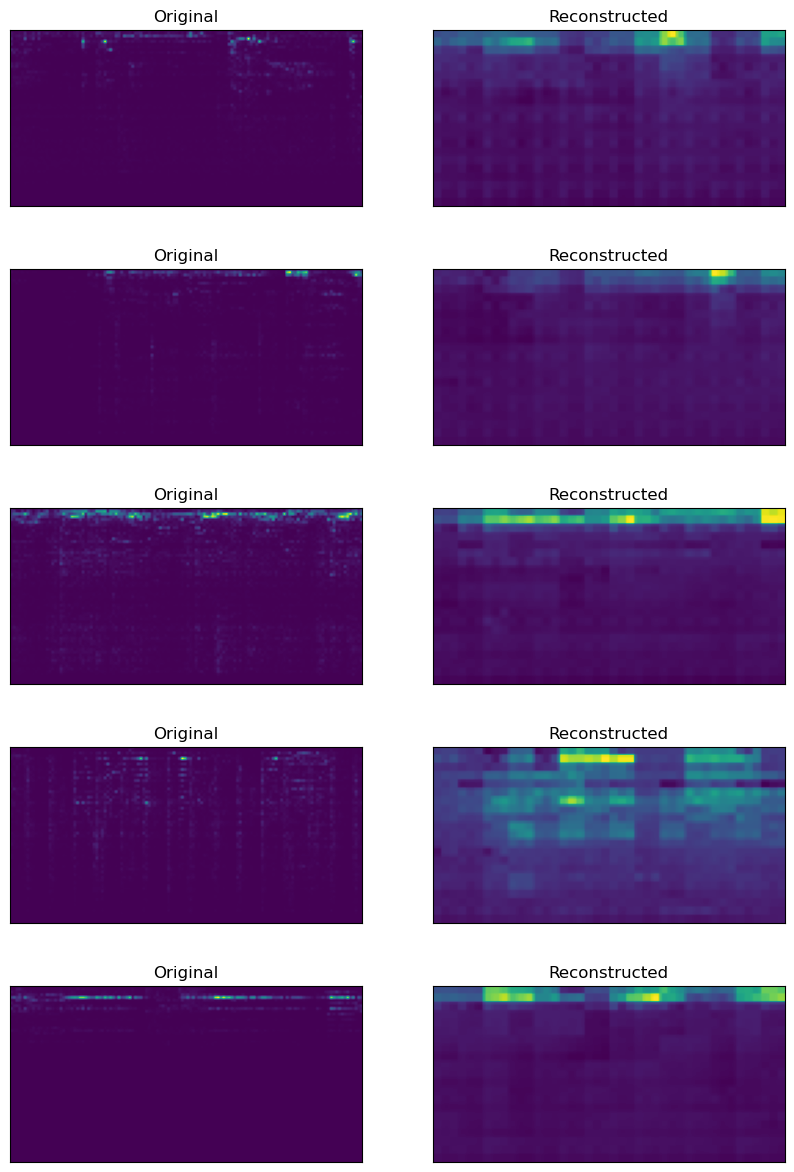

In [56]:
#load the saved model
model_loaded = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models',AE_name))
model_loaded.summary()

#plot the original and reconstructed
plot_original_reconstructed(model = model_loaded, n_figures = 5, test=test)

Now let's see the reconstruction capability on the test set of ESC-10

Found 400 files belonging to 10 classes.


Using 300 files for training.
Using 100 files for validation.


2023-09-10 20:03:00.047567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [300]
	 [[{{node Placeholder/_0}}]]
2023-09-10 20:03:00.047739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [300]
	 [[{{node Placeholder/_4}}]]


Model: "AE_Conv_prep_flatten_STFT_AudioSet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                50368     
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        51889     
                                                                 
Total params: 102,257
Trainable params: 102,257
Non-trainable params: 0
_________________________________________________________________


2023-09-10 20:03:01.754042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype float
	 [[{{node Placeholder/_20}}]]
2023-09-10 20:03:01.754364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype float
	 [[{{node Placeholder/_20}}]]


1/1 [==============================] - 0s 11ms/step


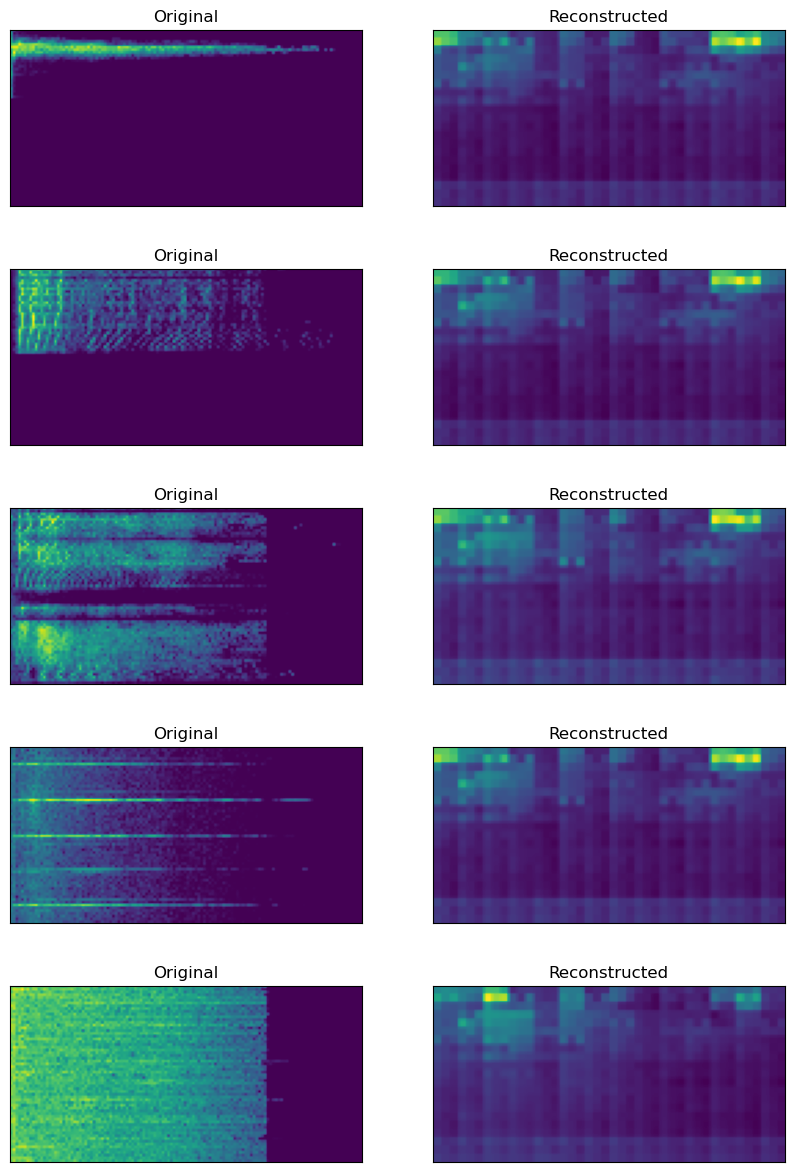

In [57]:
train, val, test, label_names = create_dataset( ESC10_path,
                                                verbose = 0,
                                                batch_size = 30,
                                                validation_split = 0.25, # this is the splitting of train vs validation + test
                                                normalize = True, # normalization preprocessing (default is true)
                                                preprocessing = preprocessing,   # "STFT" or "MFCC"
                                                show_example_batch = False,
                                                ndim=3,
                                                resize = True,
                                                new_width = 64,
                                                new_height= 128)
model_loaded = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models',AE_name))
model_loaded.summary()
# show n original and reconstructed images
plot_original_reconstructed(model = model_loaded, n_figures = 5, test=test)